<a href="https://colab.research.google.com/github/AdarshanandIITBHU/Batch_Reactor_project/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def reversible_batch_reactor(concentrations, t, k1, k_minus_1, k2, k_minus_2):

    A, B, C = concentrations

    dAdt = -k1 * A + k_minus_1 * B
    dBdt = (k1 * A - k_minus_1 * B) - (k2 * B - k_minus_2 * C)
    dCdt = k2 * B - k_minus_2 * C

    return [dAdt, dBdt, dCdt]

In [9]:
temperatures = np.linspace(290, 350, 10)     # 10 points from 290K to 350K
C0_list = np.linspace(0.5, 2.5, 10)
catalyst_levels = np.linspace(0.5, 1.5, 5)

# We'll assume the reaction is optimal at pH 7
pH_levels = [6.0, 7.0, 8.0]

# Pressure in the reactor (in atmospheres)
pressures = [1, 5, 10]

# Mixing speed (in Revolutions Per Minute)
# Better mixing can improve reaction efficiency
mixing_rpms = [100, 300, 500]

# Base rate constant
k_base = 0.1

# Simulation time
time = np.linspace(0, 100, 20)

In [10]:
print("Starting simulation for LARGE dataset...")
print("This may take several minutes...")

dataset = []
total_sims = len(temperatures) * len(C0_list) * len(catalyst_levels) * len(pH_levels) * len(pressures) * len(mixing_rpms)
sim_count = 0
for T in temperatures:
    for C0 in C0_list:
        for cat in catalyst_levels:
            for pH in pH_levels:
                for P in pressures:
                    for rpm in mixing_rpms:
                        sim_count += 1
                        if sim_count % 750 == 0:
                            print(f"Progress: {sim_count} / {total_sims} simulations complete.")

                        # pH effect: Assumes a "bell curve" effect centered around an optimal pH of 7
                        pH_effect = np.exp(-0.1 * (pH - 7)**2)

                        # Pressure effect: Assumes a slight linear increase in rate with pressure
                        pressure_effect = (1 + 0.005 * (P - 1))

                        # Mixing effect: Assumes efficiency increases with RPM, capping out
                        rpm_effect = (1 - np.exp(-0.005 * rpm))

                        # Start with the base temperature/catalyst model
                        k1_base = k_base * cat * np.exp(0.05 * (T - 300))
                        k2_base = k1_base * 0.8

                        # Apply all the new effects
                        k1 = k1_base * pH_effect * pressure_effect * rpm_effect
                        k2 = k2_base * pH_effect * pressure_effect * rpm_effect
                        k_minus_1 = k1 * 0.2
                        k_minus_2 = k2 * 0.1

                        initial_concentrations = [C0, 0, 0]

                        concentration_over_time = odeint(
                            reversible_batch_reactor,
                            initial_concentrations,
                            time,
                            args=(k1, k_minus_1, k2, k_minus_2)
                        )

                        for i, t_val in enumerate(time):
                            row = [T, C0, cat, pH, P, rpm, t_val,
                                   concentration_over_time[i, 0], # A
                                   concentration_over_time[i, 1], # B
                                   concentration_over_time[i, 2]] # C
                            dataset.append(row)

print(f"Simulation complete! Generated {len(dataset)} data points.")

Starting simulation for LARGE dataset...
This may take several minutes...
Progress: 750 / 13500 simulations complete.
Progress: 1500 / 13500 simulations complete.
Progress: 2250 / 13500 simulations complete.
Progress: 3000 / 13500 simulations complete.
Progress: 3750 / 13500 simulations complete.
Progress: 4500 / 13500 simulations complete.
Progress: 5250 / 13500 simulations complete.
Progress: 6000 / 13500 simulations complete.
Progress: 6750 / 13500 simulations complete.
Progress: 7500 / 13500 simulations complete.
Progress: 8250 / 13500 simulations complete.
Progress: 9000 / 13500 simulations complete.
Progress: 9750 / 13500 simulations complete.
Progress: 10500 / 13500 simulations complete.
Progress: 11250 / 13500 simulations complete.
Progress: 12000 / 13500 simulations complete.
Progress: 12750 / 13500 simulations complete.
Progress: 13500 / 13500 simulations complete.
Simulation complete! Generated 270000 data points.


In [11]:
column_names = ['Temperature', 'C0', 'Catalyst', 'pH', 'Pressure', 'RPM', 'Time', 'A', 'B', 'C']

df = pd.DataFrame(dataset, columns=column_names)

output_filename = 'reactor_dataset.csv'
df.to_csv(output_filename, index=False)

print(f"dataset successfully saved as '{output_filename}'")
df.info()
df.head() #

dataset successfully saved as 'reactor_dataset.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperature  270000 non-null  float64
 1   C0           270000 non-null  float64
 2   Catalyst     270000 non-null  float64
 3   pH           270000 non-null  float64
 4   Pressure     270000 non-null  int64  
 5   RPM          270000 non-null  int64  
 6   Time         270000 non-null  float64
 7   A            270000 non-null  float64
 8   B            270000 non-null  float64
 9   C            270000 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 20.6 MB


,Temperature,C0,Catalyst,pH,Pressure,RPM,Time,A,B,C
0,290.0,0.5,0.5,6.0,1,100,0.000000,0.500000,0.000000,0.000000
1,290.0,0.5,0.5,6.0,1,100,5.263158,0.472532,0.026847,0.000621
2,290.0,0.5,0.5,6.0,1,100,10.526316,0.446860,0.050750,0.002389
3,290.0,0.5,0.5,6.0,1,100,15.789474,0.422856,0.071972,0.005171
4,290.0,0.5,0.5,6.0,1,100,21.052632,0.400399,0.090753,0.008848


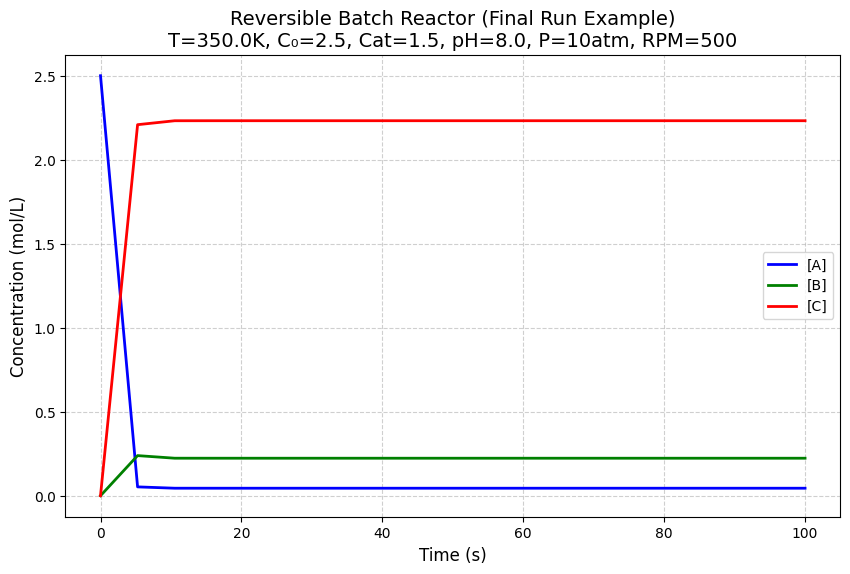

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(time, concentration_over_time[:, 0], label='[A]', color='blue', linewidth=2)
plt.plot(time, concentration_over_time[:, 1], label='[B]', color='green', linewidth=2)
plt.plot(time, concentration_over_time[:, 2], label='[C]', color='red', linewidth=2)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Concentration (mol/L)', fontsize=12)

plt.title(f'Reversible Batch Reactor (Final Run Example)\n'
          f'T={T:.1f}K, C₀={C0:.1f}, Cat={cat:.1f}, pH={pH}, P={P}atm, RPM={rpm}', fontsize=14)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()